In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [2]:
#!wget -nc https://lazyprogrammer.me/course_files/spam.csv
# !head spam.csv

In [3]:
path = 'C:\\Sandbox\\GitHub\\data\\spam.csv'

# path = tf.keras.utils.get_file('spam.csv', 'https://lazyprogrammer.me/course_files/spam.csv')

print (path)

C:\Sandbox\GitHub\data\spam.csv


In [4]:
df = pd.read_csv(path, encoding='ISO-8859-1')
# df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [7]:
# rename columns to something better
df.columns = ['labels', 'data']

In [8]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [10]:
X = df['data']
y = df['b_labels'].values

In [11]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [12]:
X_train_original = X_train
X_test_original  = X_test

In [13]:
MAX_VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

In [14]:
tokenizer.fit_on_texts(X_train)  # Convert sentences to number sequences

In [15]:
X_train = tokenizer.texts_to_sequences(X_train)

In [16]:
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
# get word -> integer mapping

word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7246 unique tokens.


In [18]:
# pad sequences so that we get a N x T matrix

X_train = pad_sequences(X_train)
print('Shape of train tensor:', X_train.shape)

# get sequence length
T = X_train.shape[1]

Shape of train tensor: (3733, 121)


In [19]:
X_test = pad_sequences(X_test, maxlen=T)
print('Shape of test tensor:', X_test.shape)

Shape of test tensor: (1839, 121)


In [20]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

In [21]:
i = Input(shape=(T,))                        # T = 121
x = Embedding(V + 1, D)(i)                   # V = 7246   D = 20
x = LSTM(M, return_sequences=True)(x)    
# x = GlobalMaxPooling1D()(x)                # this may perform little better
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 121)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 121, 20)           144940    
_________________________________________________________________
lstm (LSTM)                  (None, 121, 15)           2160      
_________________________________________________________________
flatten (Flatten)            (None, 1815)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1816      
Total params: 148,916
Trainable params: 148,916
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [23]:
history = model.fit(
  X_train,
  y_train,
  epochs=10,
  validation_data=(X_test, y_test)
)

Epoch 1/10
117/117 [==============================] - 6s 51ms/step - loss: 0.3208 - accuracy: 0.8843 - val_loss: 0.1054 - val_accuracy: 0.9690
Epoch 2/10
117/117 [==============================] - 5s 40ms/step - loss: 0.0574 - accuracy: 0.9821 - val_loss: 0.0593 - val_accuracy: 0.9831
Epoch 3/10
117/117 [==============================] - 5s 40ms/step - loss: 0.0278 - accuracy: 0.9925 - val_loss: 0.0514 - val_accuracy: 0.9853
Epoch 4/10
117/117 [==============================] - 5s 40ms/step - loss: 0.0140 - accuracy: 0.9954 - val_loss: 0.0659 - val_accuracy: 0.9842
Epoch 5/10
117/117 [==============================] - 5s 40ms/step - loss: 0.0075 - accuracy: 0.9973 - val_loss: 0.0548 - val_accuracy: 0.9886
Epoch 6/10
117/117 [==============================] - 5s 41ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.0649 - val_accuracy: 0.9880
Epoch 7/10
117/117 [==============================] - 5s 41ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 0.0619 - val_accuracy: 0.9875

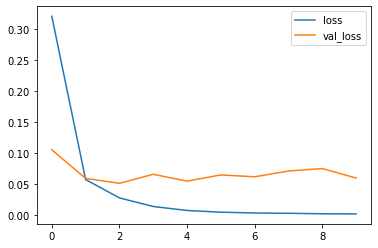

In [24]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

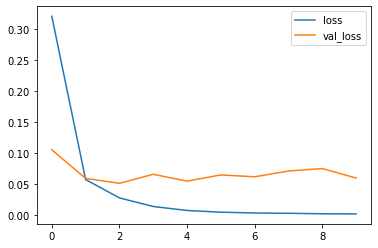

In [25]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

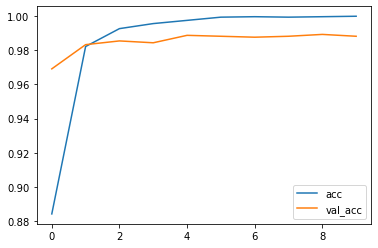

In [26]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

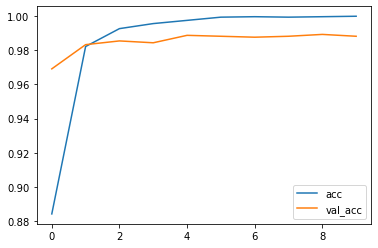

In [27]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()